In [9]:
#type = Ignore
#Importing packages
import torch
import torch.nn as nn
import torch.optim as optim
from AEModel import AE, MyDataset,AE_T
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


# Reading Dataset

In [10]:
#Read files
gene_df= pd.read_csv("../../data/master_gene_df.csv",encoding = "UTF-8")


In [11]:
#type(gene_df.iloc[:,1:].shape[1])
gene_df.iloc[:,1:].head()

,TSPYL1,TRIM40,PCGF2,GLT8D2,MLKL,TRPC1,NOP14,PTK7,SAAL1,LRRC27,...,DHX34,XAGE1B,ARL8A,KCTD8,SLX1B,CPNE6,XYLB,PKN3,RGS1,PGK1
0,24.4909,0.0,21.6829,6.5735,11.8354,4.3273,17.0597,76.0102,13.5971,4.1564,...,13.1412,0.0000,114.5090,0.0000,0.0000,0.0000,3.3251,12.6058,84.0652,515.9193
1,12.3660,0.0,24.3977,12.3956,6.7753,3.4088,26.2333,35.2884,11.8437,1.0874,...,7.5863,0.1099,93.0715,0.3294,0.0000,0.0065,2.6886,11.6752,82.8888,1444.9458
2,41.5962,0.0,22.0650,5.2642,4.2537,0.8289,25.3952,64.0538,34.0402,0.9742,...,28.4462,0.0000,82.7308,0.0277,0.1222,0.0000,4.2784,7.2688,39.6819,632.6572
3,30.8982,0.0,14.7856,6.6122,5.0003,0.9631,30.4176,69.6955,33.3931,0.7268,...,20.8353,0.0000,168.9003,0.0000,0.0229,0.0471,7.0244,15.3454,26.6279,682.4480
4,14.1942,0.0,6.5414,5.0653,9.2886,0.9809,30.6175,83.9273,10.7675,2.1584,...,15.3766,0.0000,106.8909,0.0000,0.0000,0.0414,1.1573,3.3286,154.2987,436.9842


In [12]:
# DataLoader is used to load the dataset for training
pd_train_dataset, pd_test_dataset = train_test_split(gene_df.iloc[:,1:], test_size=0.2)

X_train_sc = StandardScaler().fit_transform(pd_train_dataset)

X_test_sc = StandardScaler().fit_transform(pd_test_dataset)

X_full_sc = StandardScaler().fit_transform(gene_df.iloc[:,1:])

In [13]:
data_train = MyDataset(X_train_sc)
data_test = MyDataset(X_test_sc)
data_full = MyDataset(X_full_sc)

In [14]:
train_loader=DataLoader(data_train, batch_size=50, shuffle=False)
test_loader = DataLoader(data_test, batch_size=50)

In [30]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE_T(input_shape = len(X_train_sc[0])).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

In [31]:
losses_train = []
losses_val = []

epochs=500
for epoch in range(epochs):
    model.train()
    loss = 0
    for batch_features in train_loader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        batch_features = batch_features.to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        lol, outputs = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    losses_train.append(loss)


    #For Valid Loss
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            code, outputs = model(batch)
            loss_val =criterion(outputs, batch)
            val_loss += loss_val.item()

    val_loss = val_loss / len(test_loader)
    losses_val.append(val_loss)


    # display the epoch training loss
    print("epoch : {}/{}, train_loss = {:.6f}".format(epoch + 1, epochs, loss))
    print("epoch : {}/{}, val_loss = {:.6f}".format(epoch + 1, epochs, val_loss))

epoch : 1/500, train_loss = 1.824395
epoch : 1/500, val_loss = 3.987213
epoch : 2/500, train_loss = 1.757535
epoch : 2/500, val_loss = 2.136973
epoch : 3/500, train_loss = 1.707388
epoch : 3/500, val_loss = 1.900142
epoch : 4/500, train_loss = 1.662113
epoch : 4/500, val_loss = 1.799905
epoch : 5/500, train_loss = 1.619903
epoch : 5/500, val_loss = 1.731619
epoch : 6/500, train_loss = 1.579950
epoch : 6/500, val_loss = 1.677388
epoch : 7/500, train_loss = 1.541862
epoch : 7/500, val_loss = 1.631017
epoch : 8/500, train_loss = 1.505302
epoch : 8/500, val_loss = 1.588291
epoch : 9/500, train_loss = 1.470164
epoch : 9/500, val_loss = 1.548403
epoch : 10/500, train_loss = 1.436386
epoch : 10/500, val_loss = 1.510835
epoch : 11/500, train_loss = 1.403810
epoch : 11/500, val_loss = 1.475304
epoch : 12/500, train_loss = 1.372384
epoch : 12/500, val_loss = 1.441194
epoch : 13/500, train_loss = 1.342087
epoch : 13/500, val_loss = 1.407299
epoch : 14/500, train_loss = 1.312897
epoch : 14/500, va

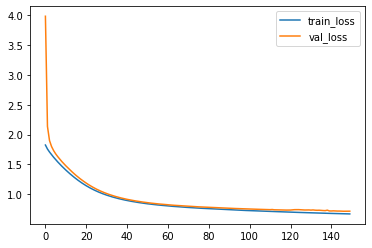

In [36]:
plt.plot(losses_train[:150], label = 'train_loss')
plt.plot(losses_val[:150], label = 'val_loss')
plt.legend()

In [37]:
# Full Gene Autoencoder Taining

data_full = MyDataset(X_full_sc)
full_loader = DataLoader(data_full, batch_size=50)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AE_T(input_shape = len(X_full_sc[0])).to(device)
optimizer = optim.Adam(model.parameters(),lr=1e-3)
criterion = nn.MSELoss()



In [38]:
losses_train_final = []

epochs=150
for epoch in range(epochs):
    model.train()
    loss = 0
    for batch_features in full_loader:
        batch_features = batch_features.to(device)
        
        optimizer.zero_grad()
        
        code, outputs = model(batch_features)
        
        train_loss = criterion(outputs, batch_features)
        
        train_loss.backward()
        
        optimizer.step()
        
        loss += train_loss.item()
    
    loss = loss / len(train_loader)
    losses_train_final.append(loss)

    print("epoch : {}/{}, train_loss = {:.6f}".format(epoch + 1, epochs, loss))

epoch : 1/150, train_loss = 2.371810
epoch : 2/150, train_loss = 2.278350
epoch : 3/150, train_loss = 2.208492
epoch : 4/150, train_loss = 2.145116
epoch : 5/150, train_loss = 2.085704
epoch : 6/150, train_loss = 2.029379
epoch : 7/150, train_loss = 1.976472
epoch : 8/150, train_loss = 1.926855
epoch : 9/150, train_loss = 1.878786
epoch : 10/150, train_loss = 1.833050
epoch : 11/150, train_loss = 1.789027
epoch : 12/150, train_loss = 1.747618
epoch : 13/150, train_loss = 1.708049
epoch : 14/150, train_loss = 1.670141
epoch : 15/150, train_loss = 1.634714
epoch : 16/150, train_loss = 1.600824
epoch : 17/150, train_loss = 1.568573
epoch : 18/150, train_loss = 1.538861
epoch : 19/150, train_loss = 1.510168
epoch : 20/150, train_loss = 1.482938
epoch : 21/150, train_loss = 1.458832
epoch : 22/150, train_loss = 1.435410
epoch : 23/150, train_loss = 1.411999
epoch : 24/150, train_loss = 1.390832
epoch : 25/150, train_loss = 1.371119
epoch : 26/150, train_loss = 1.353508
epoch : 27/150, train

In [39]:
data = torch.tensor(X_full_sc,dtype=torch.float32)
model.eval()
with torch.no_grad():
    out,out2 = model(data)

In [40]:
latent_df = pd.DataFrame(out)
latent_df.insert(0,'file_name',gene_df['file_name'])
latent_df

,file_name,0,1,2,3,4,5,6,7,8,...,118,119,120,121,122,123,124,125,126,127
0,5faf8a12-a2aa-44f1-b099-02106766ec94,-0.723040,-0.727643,0.481543,0.097189,-0.044624,-0.156007,-0.154831,0.664276,-0.689005,...,-0.183494,1.492558,-0.319100,-0.367510,0.127676,-0.419394,0.314201,0.629479,-0.005811,0.024343
1,6855a406-c085-45c7-b789-981786f0c775,-0.723040,-0.160989,0.200158,-1.077208,-0.199147,0.287531,-0.081362,0.142628,-0.230718,...,0.660066,0.090072,-0.068541,-1.042671,0.230443,-0.795689,0.197465,-0.606612,-0.005811,0.478020
2,e2445ad6-2a6a-4ec3-84d8-93cc3c180a58,0.718881,-0.624347,-0.336003,-2.066164,0.825467,0.951794,-0.547016,0.142628,0.017885,...,-0.029410,-0.583218,-1.108014,0.338714,0.632016,-0.585889,-0.267355,-0.606612,0.605120,0.032335
3,cded92df-9367-4ee5-930c-6c87bf2c8eb0,1.438180,-0.557001,-0.336003,-2.066164,2.620411,2.022248,-0.547016,0.142628,0.599585,...,-0.312819,-0.583218,-1.087689,0.193324,0.576623,0.221532,-0.435843,1.303435,1.688595,-0.274273
4,4b167e70-e4e6-47f7-9fe9-11cf20f0d442,-0.521697,-0.107451,-0.336003,-1.552637,-0.199147,-0.156007,-0.442018,0.142628,0.148820,...,0.095978,-0.095162,-0.765949,-0.027248,0.209361,-0.867946,-0.212317,-0.440243,-0.005811,-0.348813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
949,1120d776-47df-4f72-862e-427d3c44dd43,0.761489,1.552966,0.894864,-2.066164,0.818666,0.833590,0.470497,1.263454,-1.091603,...,1.533095,0.444737,-0.959472,-0.085191,0.179598,1.321581,2.732470,2.351571,2.095917,-0.348813
950,f9cd1c16-3be3-415c-8d7b-9249c3b1c7fa,1.115692,-0.810143,-0.155077,-2.066164,0.275015,0.345515,-0.547016,0.249808,-1.091603,...,0.249223,-0.583218,-1.108014,-1.170032,0.391803,-0.889050,0.003858,-0.606612,1.162846,2.433268
951,218eb2f2-24b1-4e41-9071-26ed97a2edc1,-0.162710,1.692431,0.869310,0.065778,-0.199147,-0.156007,2.086387,0.142628,-0.936617,...,1.477265,0.032020,0.128918,-0.728673,2.263087,1.171138,-0.435843,-0.606612,-0.005811,-0.100294
952,978939fa-a27f-46ff-9120-7a43e3588b28,-0.723040,-1.070742,3.538204,-0.009267,2.680707,2.650743,1.702279,5.178845,3.526742,...,-0.591628,1.556053,-1.108014,3.250179,0.490337,-0.889050,3.118964,2.401170,1.250437,-0.348813


In [41]:
latent_df.to_csv("../../data/gene_df_128_tw.csv", index=False)